In [33]:
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.transform.transform as transform
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns
%load_ext autoreload
%autoreload 2
sns.set_style("darkgrid")

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

In [5]:
PATH_EXPERIMENT_ROD = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/8-FENE-vary-l_K-vary-d_end-rod/f7d1a660"
PATH_EXPERIMENT_FLEXIBLE = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results/FENE-beadspring-vary-l_K-vary-d_end/6-FENE-vary-l_K-vary-d_end-flexible/f7d1a660"
PATH_REL_ETE = "data/processed/ete.csv"

In [9]:
conf_rod = config.read_experiment_config(pathlib.Path(PATH_EXPERIMENT_ROD) / "8-FENE-vary-l_K-vary-d_end-rod.toml")
conf_rod

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='72:00:00', partition='romeo', nodes=2, tasks_per_node=128, ntasks=256, cpus_per_task=1, mem_per_cpu=1000), lammps_executable='/scratch/ws/0/s4610340-bt-eea1-md-workspace/bin/lammps-patch_23Jun2022_update4/lmp_omp_romeo_opt', lmod_modules='modenv/hiera GCC/11.3.0 OpenMPI/4.1.4 Python/3.9.6', simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K-vary-d_end.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/data/experiment_results'), n_partitions=4, n_tasks_per_partition=64, variables={'kappa_start': 49.2, 'kappa_delta': 4, 'kappa_n_values': 4, 'm_end': 1.5, 'd_end_start': 5, 'd_end_delta': 5, 'd_end_n_values': 3, 'n_relax_steps': 20000000, 'n_equilibrium_steps': 10000000}), initial_system_config=SystemCreatorConfig(system_type='create', job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntas

In [6]:
df_ete_rod = pd.read_csv(pathlib.Path(PATH_EXPERIMENT_ROD) / PATH_REL_ETE, index_col=["kappa", "d_end", "molecule-ID", "t"])
df_ete_rod

R_x       R_y      R_z          R
kappa d_end molecule-ID t                                               
49.2  5     1           0        -10.07540  -1.09939 -60.2637  61.110031
                        100000    -0.35463  -5.05908 -56.0428  56.271800
                        200000     3.35447  -3.27996 -52.8003  53.008323
                        300000   -10.22410  -4.48803 -51.2273  52.430057
                        400000   -10.53010 -12.71720 -55.8817  58.269843
...                                    ...       ...      ...        ...
61.2  15    500         29960000  21.14280 -15.65120 -52.4999  58.721525
                        29970000  22.82740 -14.88190 -50.7373  57.591968
                        29980000  19.53630 -14.02700 -50.3273  55.778678
                        29990000  19.20620 -11.42430 -50.6464  55.357480
                        30000000  19.18190 -12.49360 -52.1306  56.935356

[7206000 rows x 4 columns]

In [7]:
df_ete_flexible = pd.read_csv(pathlib.Path(PATH_EXPERIMENT_FLEXIBLE) / PATH_REL_ETE, index_col=["kappa", "d_end", "molecule-ID", "t"])
df_ete_flexible

R_x       R_y       R_z          R
kappa d_end molecule-ID t                                                
1.0   5     1           0        -10.07540  -1.09939 -60.26370  61.110031
                        100000    -1.90036   2.54618 -31.84010  31.998224
                        200000    -8.41566  -2.62909 -18.48540  20.480368
                        300000    -5.66938   7.97108 -11.94320  15.437617
                        400000   -11.15780   1.61475  -9.84013  14.964360
...                                    ...       ...       ...        ...
6.1   15    500         24960000   3.17744 -13.14390  11.04360  17.459076
                        24970000   3.56088 -15.22160  11.83670  19.608275
                        24980000   3.66208 -17.05790  10.34220  20.281614
                        24990000   3.55062 -17.07700  13.44050  22.019943
                        25000000   3.64627 -14.48780  14.37340  20.731287

[6906000 rows x 4 columns]

## Process Data

In [55]:
df_ete_mean_rod = df_ete_rod.groupby(["kappa", "d_end", "t"]).agg({"R": lambda Rs: np.mean(Rs**2)}).rename({"R": "R^2"}, axis=1)
df_ete_mean_rod["t/LJ"] = df_ete_mean_rod.index.get_level_values("t").map(lambda t: t*0.0025)
df_ete_mean_rod

R^2     t/LJ
kappa d_end t                             
49.2  5     0         3734.432092      0.0
            100000    3108.596158    250.0
            200000    2981.252879    500.0
            300000    2912.749405    750.0
            400000    2876.733627   1000.0
...                           ...      ...
61.2  15    29960000  2737.615221  74900.0
            29970000  2739.709901  74925.0
            29980000  2736.681069  74950.0
            29990000  2743.145130  74975.0
            30000000  2739.627806  75000.0

[14412 rows x 2 columns]

## Equilibrium stats

In [10]:
t_equilibrium_rod = conf_rod.simulation_config.variables["n_relax_steps"]
t_equilibrium_rod

20000000

In [11]:
df_ete_rod_equi = df_ete_rod.iloc[df_ete_rod.index.get_level_values("t") >= t_equilibrium_rod]
df_ete_rod_equi

R_x      R_y      R_z          R
kappa d_end molecule-ID t                                             
49.2  5     1           20000000 -12.2221 -37.4273 -36.7689  53.871463
                        20010000 -12.0117 -34.5164 -38.9378  53.402388
                        20020000 -16.2076 -34.2460 -38.5348  54.040777
                        20030000 -17.6853 -33.6999 -37.6246  53.516947
                        20040000 -16.2115 -32.9681 -38.7671  53.409703
...                                   ...      ...      ...        ...
61.2  15    500         29960000  21.1428 -15.6512 -52.4999  58.721525
                        29970000  22.8274 -14.8819 -50.7373  57.591968
                        29980000  19.5363 -14.0270 -50.3273  55.778678
                        29990000  19.2062 -11.4243 -50.6464  55.357480
                        30000000  19.1819 -12.4936 -52.1306  56.935356

[6006000 rows x 4 columns]

In [56]:
df_ete_mean_rod_equi = df_ete_mean_rod.iloc[df_ete_mean_rod.index.get_level_values("t") >= t_equilibrium_rod]
df_ete_mean_rod_equi

R^2     t/LJ
kappa d_end t                             
49.2  5     20000000  2533.642696  50000.0
            20010000  2533.731117  50025.0
            20020000  2531.135830  50050.0
            20030000  2553.817883  50075.0
            20040000  2551.383864  50100.0
...                           ...      ...
61.2  15    29960000  2737.615221  74900.0
            29970000  2739.709901  74925.0
            29980000  2736.681069  74950.0
            29990000  2743.145130  74975.0
            30000000  2739.627806  75000.0

[12012 rows x 2 columns]

In [12]:
l_b = conf_rod.initial_system_config.system_config.bond_length
l_b

0.97

In [13]:
L_contour = l_b*(conf_rod.initial_system_config.system_config.n_monomers-1)
L_contour

61.11

In [19]:
m_end = conf_rod.simulation_config.variables["m_end"]
m_end

1.5

In [18]:
l_ks_rod: np.ndarray = kremer_grest.bare_kuhn_length(np.array(df_ete_rod.index.get_level_values("kappa").unique()), l_b)
l_ks_rod / L_contour

array([1.54603175, 1.67301587, 1.8       , 1.92698413])

In [22]:
ds_rod: np.ndarray = df_ete_rod.index.get_level_values("d_end").unique().to_numpy()
ds_rod

array([ 5, 10, 15])

In [23]:
zetas_end_rod = ds_rod / m_end
zetas_end_rod

array([ 3.33333333,  6.66666667, 10.        ])

In [81]:
df_ete_change_rod_equi = transform.calculate_ens_avg_df_ete_change_kappas_dend(df_ete_rod_equi)
df_ete_change_rod_equi["t/LJ"] = df_ete_change_rod_equi.index.get_level_values("t").map(lambda t: t*0.0025)
df_ete_change_rod_equi["t/LJ"] = df_ete_change_rod_equi["t/LJ"] - df_ete_change_rod_equi["t/LJ"].min()
df_ete_change_rod_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_rod_equi["kappa"], l_b=l_b)
df_ete_change_rod_equi

,dR^2,kappa,d_end,t/LJ,l_K
t,,,,,
20000000,0.000000,49.2,5,0.0,94.478
20010000,13.258601,49.2,5,25.0,94.478
20020000,25.591243,49.2,5,50.0,94.478
20030000,33.795904,49.2,5,75.0,94.478
20040000,43.807090,49.2,5,100.0,94.478
...,...,...,...,...,...
29960000,1827.097213,61.2,15,24900.0,117.758
29970000,1830.099266,61.2,15,24925.0,117.758
29980000,1831.503714,61.2,15,24950.0,117.758


### Compare MSD at specific $l_K$ for different $\zeta$ values

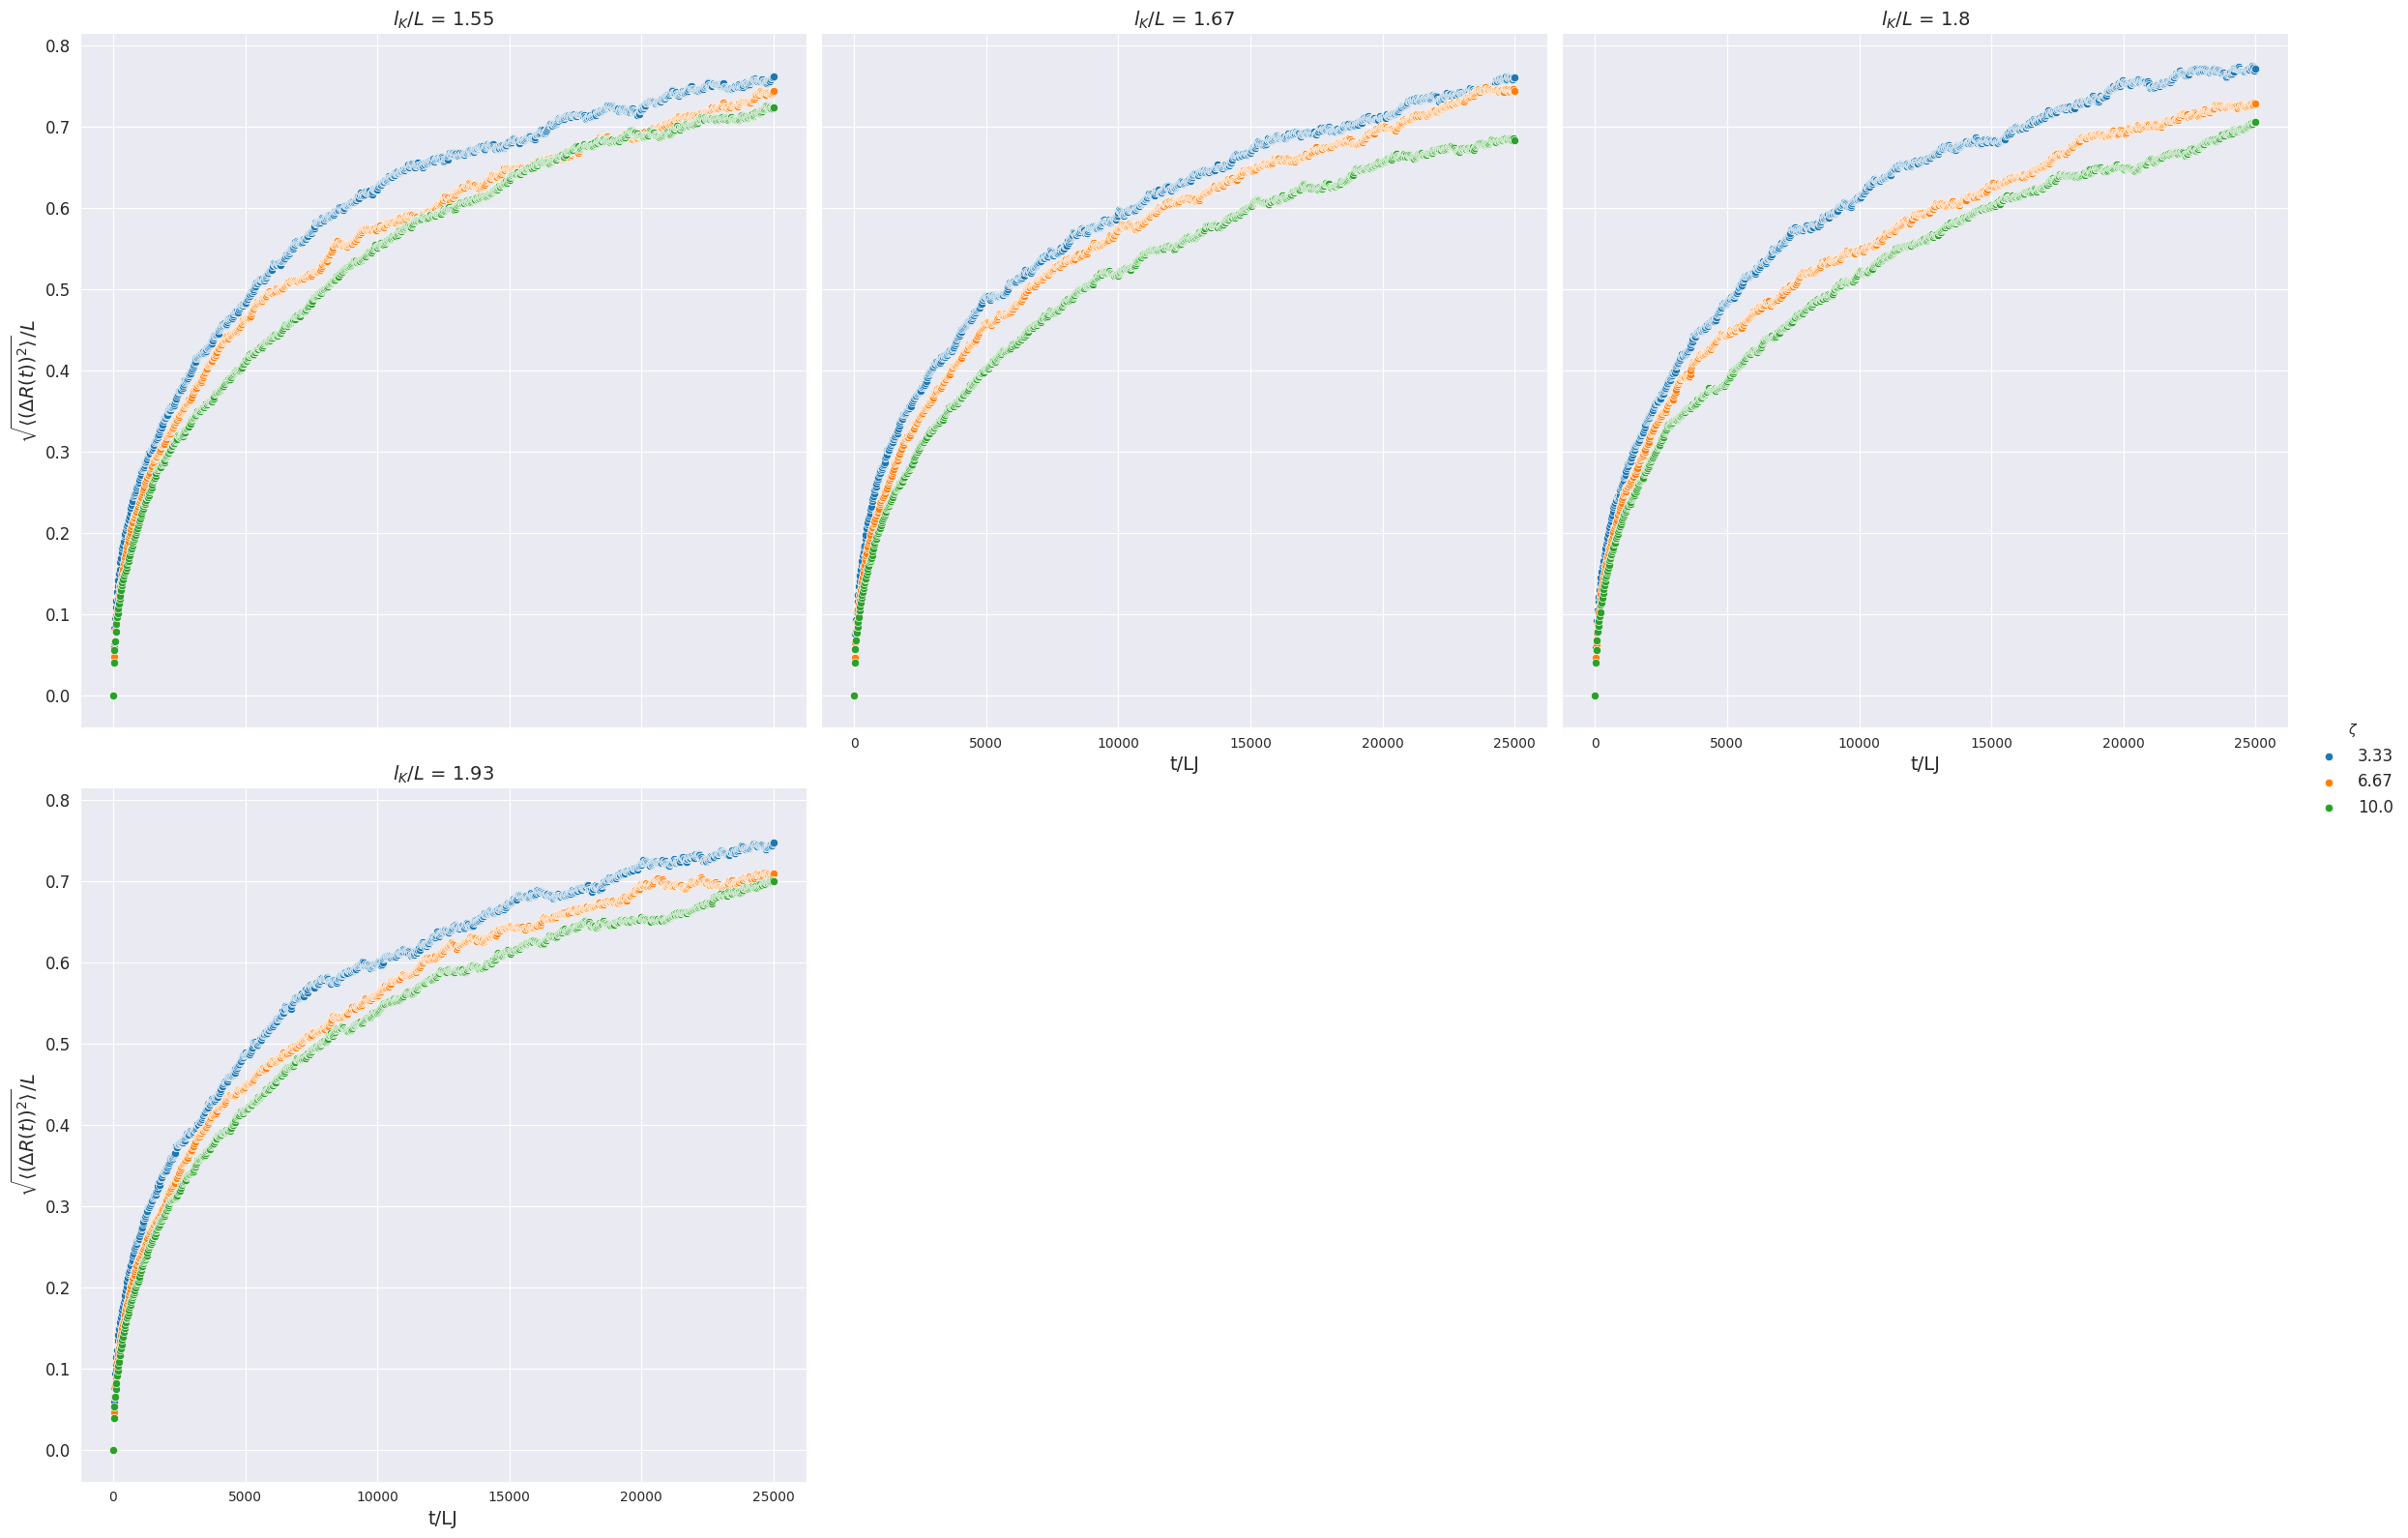

In [60]:
d_end_colors = sns.color_palette(n_colors=len(ds_rod))
l_K_colors = sns.color_palette(n_colors=len(l_ks_rod))

def plot_raw_dR():
    df = df_ete_change_rod_equi.copy()
    df["l_K"] = (kremer_grest.bare_kuhn_length(df["kappa"], l_b=l_b) / L_contour).round(2).astype("category")
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour
    zeta_col = "$ \zeta $"
    df[zeta_col] = (df["d_end"] / m_end).round(2).astype("category")

    g = sns.FacetGrid(
        df.reset_index(),
        col="l_K",
        col_wrap=3,
        hue=zeta_col,
        sharey=True,
        sharex=True,
        palette=l_K_colors,
        legend_out=True,
        height=8
    )

    g.set_titles(col_template="$l_K / L$ = {col_name}")

    g.map(
        sns.scatterplot,
        "t/LJ",
        dR_col
    )

    g.add_legend()

plot_raw_dR()

### Compare MSD at specific $\zeta$ for different $l_K$ values

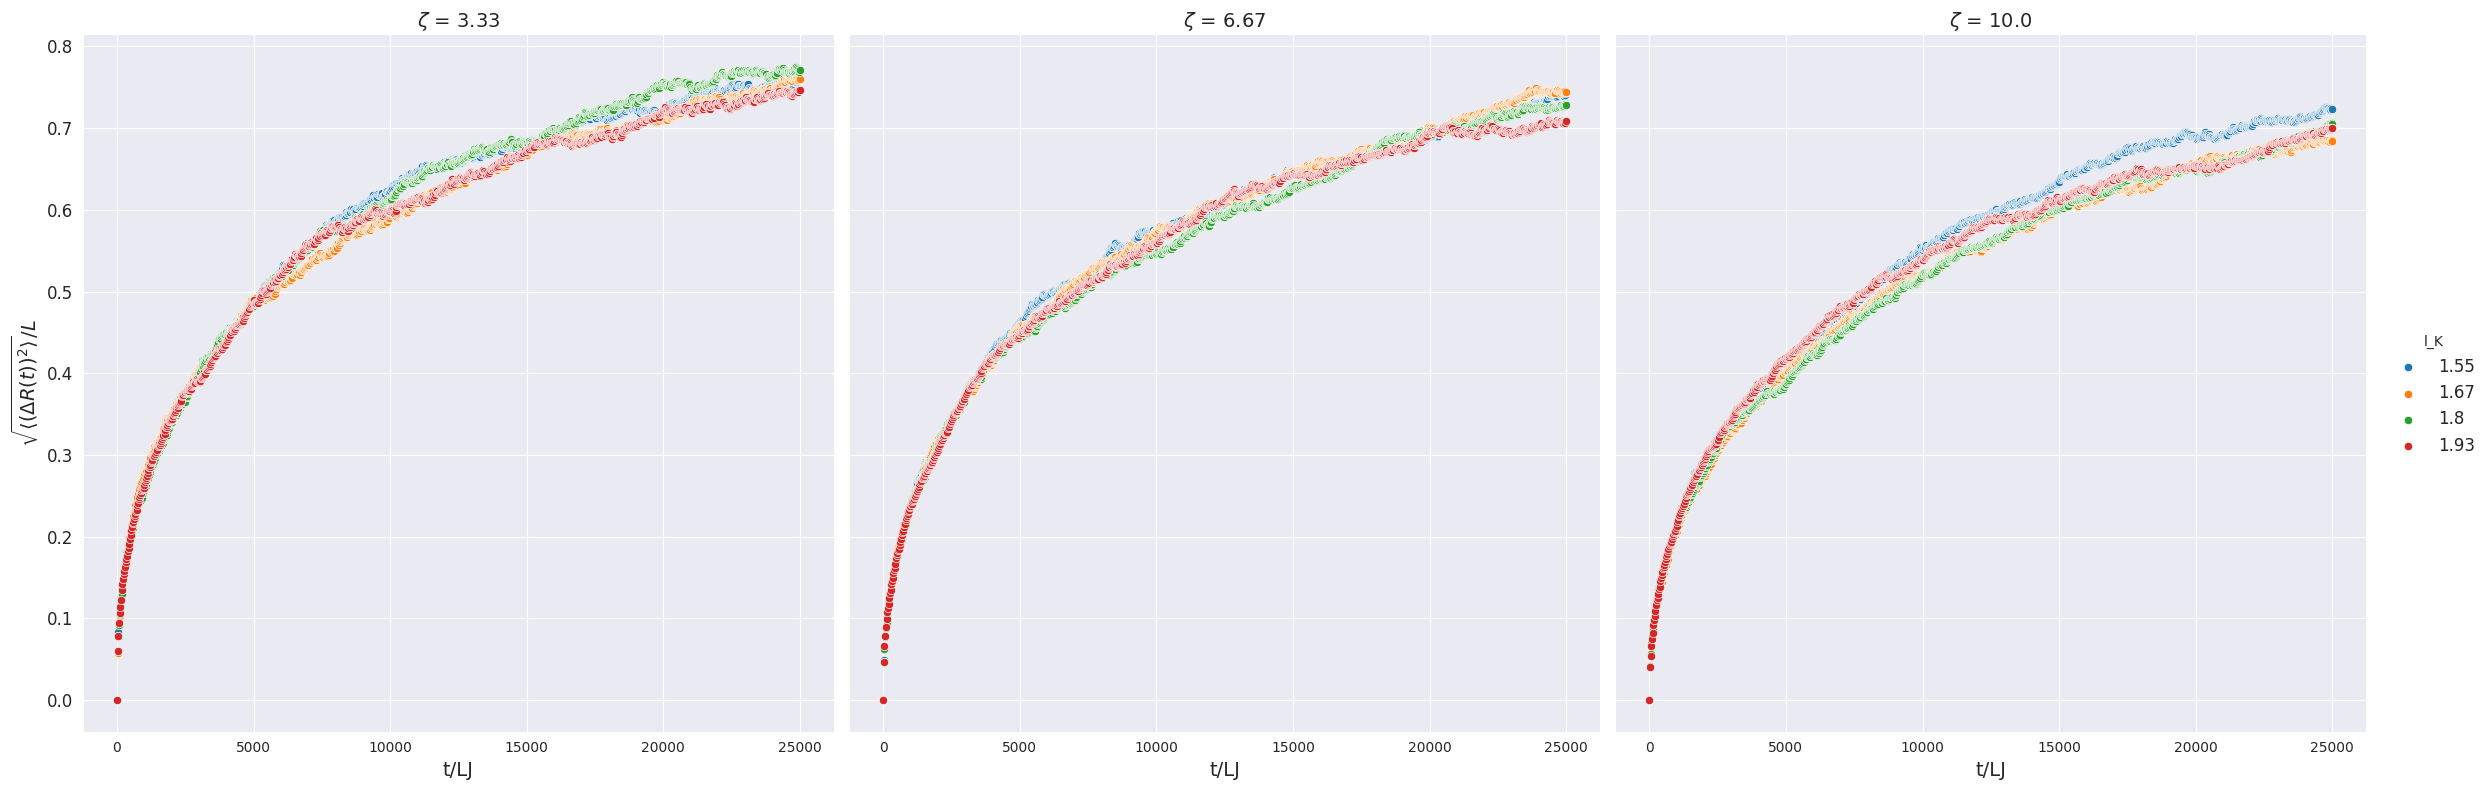

In [61]:
d_end_colors = sns.color_palette(n_colors=len(ds_rod))
l_K_colors = sns.color_palette(n_colors=len(l_ks_rod))

def plot_raw_dR():
    df = df_ete_change_rod_equi.copy()
    df["l_K"] = (kremer_grest.bare_kuhn_length(df["kappa"], l_b=l_b) / L_contour).round(2).astype("category")
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour
    zeta_col = "$ \zeta $"
    df[zeta_col] = (df["d_end"] / m_end).round(2).astype("category")

    g = sns.FacetGrid(
        df.reset_index(),
        col=zeta_col,
        col_wrap=3,
        hue="l_K",
        sharey=True,
        sharex=True,
        palette=l_K_colors,
        legend_out=True,
        height=8
    )

    g.map(
        sns.scatterplot,
        "t/LJ",
        dR_col
    )

    g.add_legend()

plot_raw_dR()

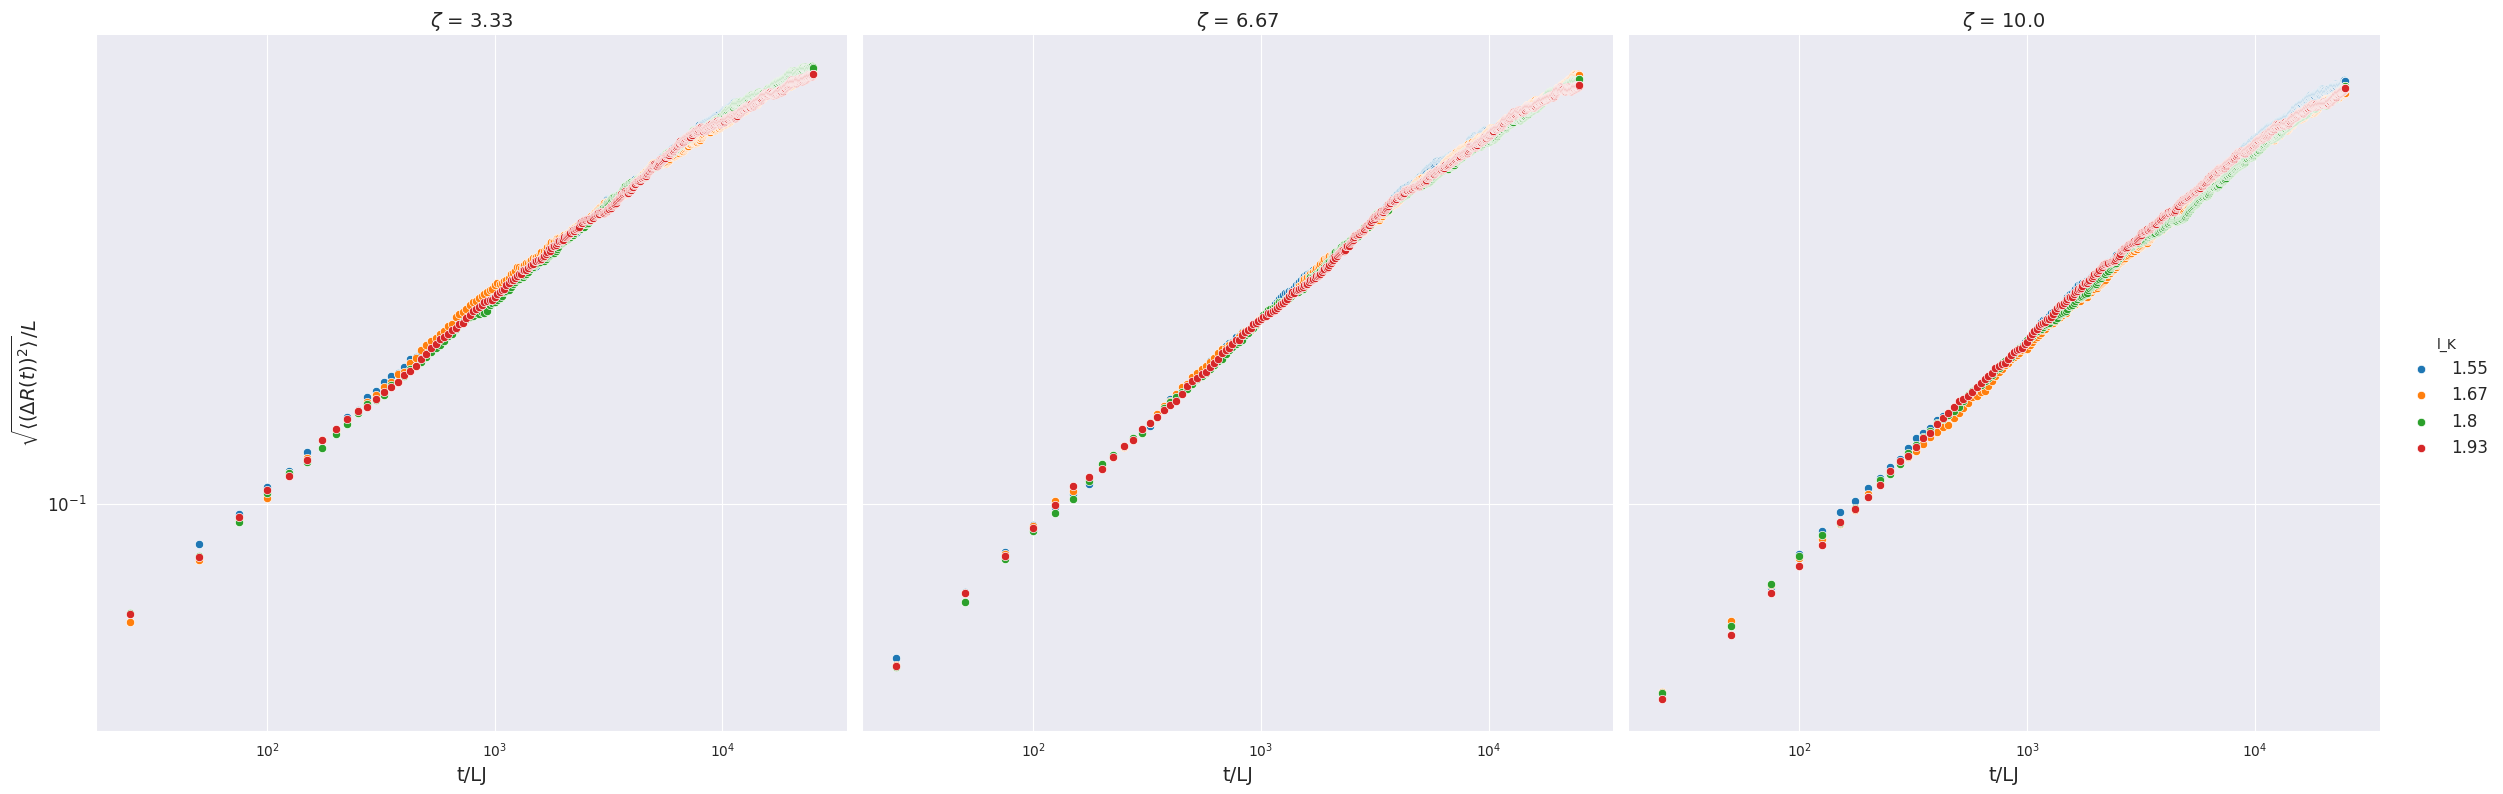

In [62]:
d_end_colors = sns.color_palette(n_colors=len(ds_rod))
l_K_colors = sns.color_palette(n_colors=len(l_ks_rod))

def plot_raw_dR():
    df = df_ete_change_rod_equi.copy()
    df["l_K"] = (kremer_grest.bare_kuhn_length(df["kappa"], l_b=l_b) / L_contour).round(2).astype("category")
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour
    zeta_col = "$ \zeta $"
    df[zeta_col] = (df["d_end"] / m_end).round(2).astype("category")

    g = sns.FacetGrid(
        df.reset_index(),
        col=zeta_col,
        col_wrap=3,
        hue="l_K",
        sharey=True,
        sharex=True,
        palette=l_K_colors,
        legend_out=True,
        height=8
    )

    g.map(
        sns.scatterplot,
        "t/LJ",
        dR_col
    )

    g.set(xscale="log", yscale="log")

    g.add_legend()

plot_raw_dR()

### MSD for Grill-related $l_K$ and relevant $\zeta$

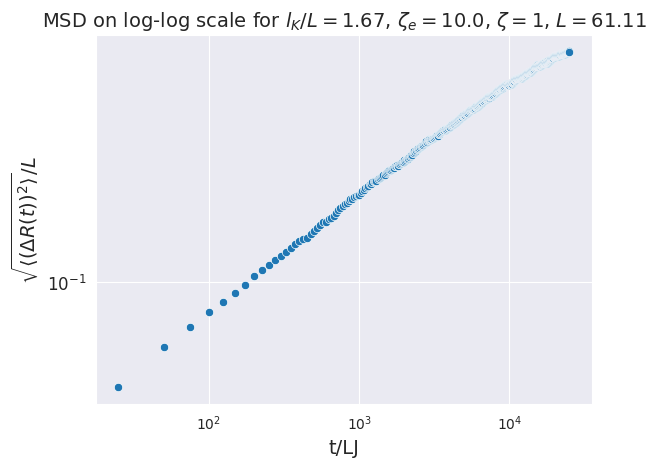

In [73]:
def _plot_msd_grill():
    df = df_ete_change_rod_equi.copy()
    df["l_K"] = (kremer_grest.bare_kuhn_length(df["kappa"], l_b=l_b) / L_contour).round(2).astype("category")
    dR_col = "$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} / L$"
    df[dR_col] = np.sqrt(df["dR^2"]) / L_contour
    zeta_col = "$ \zeta $"
    df[zeta_col] = (df["d_end"] / m_end).round(2).astype("category")

    ax: plt.Axes = sns.scatterplot(df.loc[(df["l_K"]==1.67) & (df[zeta_col]==10.0)], x="t/LJ", y=dR_col)
    ax.set(xscale="log", yscale="log", title=f"MSD on log-log scale for $l_K/L=1.67$, $\zeta_e=10.0$, $\zeta=1$, $L={L_contour}$")

_plot_msd_grill()

In [126]:
def _calculate_window_log_slope(data: pd.Series) -> float:
    return np.polyfit(np.log10(data.index), np.log10(data), 1)[0]

def _calculate_scaling_factor(df_ete_change: pd.DataFrame, window: int):
    return df_ete_change.loc[df_ete_change["t/LJ"] > .0001].groupby(["l_K", "d_end"])[["dR^2", "t/LJ"]].rolling(window=window, on="t/LJ", min_periods=10).apply(
        _calculate_window_log_slope
    )

df_rod_scaling_exp = _calculate_scaling_factor(df_ete_change_rod_equi, 1000).rename({"dR^2": "alpha"}, axis=1)
df_rod_scaling_exp

alpha     t/LJ
l_K     d_end t                          
94.478  5     20010000       NaN     25.0
              20020000       NaN     50.0
              20030000       NaN     75.0
              20040000       NaN    100.0
              20050000       NaN    125.0
...                          ...      ...
117.758 15    29960000  0.746938  24900.0
              29970000  0.746833  24925.0
              29980000  0.746729  24950.0
              29990000  0.746625  24975.0
              30000000  0.746518  25000.0

[12000 rows x 2 columns]

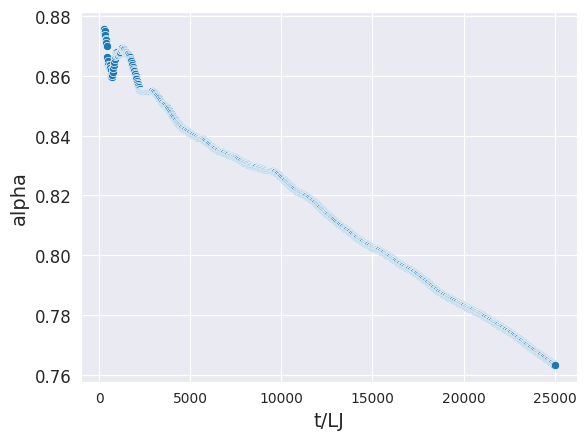

In [127]:
def _plot_scaling_exp():
    df: pd.DataFrame = df_rod_scaling_exp.copy()
    df.reset_index(inplace=True, drop=False)
    df["l_K"] = (df["l_K"] / L_contour).round(2).astype("category")
    zeta_col = "$ \zeta $"
    df[zeta_col] = (df["d_end"] / m_end).round(2).astype("category")

    sns.scatterplot(
        df.loc[(df[zeta_col]==10.0) & (df["l_K"]==1.67)],
        x="t/LJ",
        y="alpha"
    )

_plot_scaling_exp()